### Roughly patterned after LeNet-5
max instead of average pooling

In [2]:
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
import time
from IPython import display
import pandas as pd

In [3]:
# grayscale and inline plotting
%matplotlib inline
plt.rcParams['image.cmap'] = 'gray'

In [4]:
# using scipy's 2d convolution function
conv2 = scipy.signal.convolve2d # modes include "full", "valid", and "same"

In [17]:
# visualization functions

def plot_image(image):
    nr, nc = image.shape 
    extent = [-0.5, nc-0.5, nr-0.5, -0.5] 
    plt.imshow(image, extent=extent, origin='upper', interpolation='nearest')
    
def visualize(iter, errsq, errcl, x7, x6, x5, x4, x0, w1):

    errsq = np.divide(
        np.cumsum(errsq[: iter + 1]),
        range(1, iter + 2)
    )
    
    errcl = np.divide(
        np.cumsum(errcl[: iter + 1]),
        range(1, iter + 2)
    )
    
    display.clear_output(wait=True)

    plt.subplot(4,3,1)
    plt.plot(errsq)
    plt.ylim(0,1)
    plt.title("average squared error")
    
    plt.subplot(4,3,2)
    plt.plot(errcl)
    plt.ylim(0,1)
    plt.title("average classification error")
    
    plt.subplot(4,3,3)
    plt.bar(range(len(x7)),x7)
    plt.title("class confidences")
    
    plt.subplot(4,3,4)
    plt.hist(x6)
    plt.title("x5 activations")
    
    plt.subplot(4,3,5)
    plt.hist(x5)
    plt.title("x4 activations")
    
    plt.subplot(4,3,6)
    plot_image(x0[0])
    plt.title("input image")
    
#     for i in range(w1.shape[0]):
#         for j in range(w1.shape[1]):
#             if j == 0:
#                 plt.subplot(4,3,7+i)
#                 plot_image(w1[i,j])
#                 plt.title("w1 kernel channel " + str(i))

    plt.subplots_adjust(wspace=0.5)
    plt.gcf().set_size_inches(18.5, 10.5)
    display.display(plt.gcf())

In [6]:
def maxpool(images):
    # 2x2 max pooling for set of images
    # returns MAXIMA, WINNERS
    # MAXIMA 2x smaller image, maximum of each 2x2 patch
    # WINNERS 2x smaller image, argmax (1..4) of each 2x2 patch

    [k, m, n] = images.shape  # mxn images, k of them
    # reshape to k x 2 x m/2 x 2 x n/2
    im_re = np.reshape(images, (k, m/2, 2, n/2, 2))
    maxima = np.amax(np.amax(im_re, 4), 2)
    
    # obtain "flat" indices for each element
    inds = np.reshape(np.array(range(im_re.size)), im_re.shape)
    
    # run two-step argmax to determine winning indices
    curr_inds = np.argmax(im_re, 4)
    dim0, dim1, dim2, dim3 = np.indices(curr_inds.shape)
    inds = inds[dim0, dim1, dim2, dim3, curr_inds]
    im_re = np.amax(im_re, 4)
    curr_inds = np.argmax(im_re, 2)
    dim0, dim1, dim3 = np.indices(curr_inds.shape)
    winners = inds[dim0, dim1, curr_inds, dim3]
    return maxima, winners

def maxpoolback(delta_out, winners):
    # backprop through 2x2 max pooling
    #
    # DELTA_IN image, deltas
    # DELTA_OUT 2x smaller image, deltas
    # WINNERS 2x smaller image, argmax (1..4) of each 2x2 patch

    [k, m, n] = delta_out.shape;  # mxn images, k of them
    delta_in = np.zeros((k,2*m,2*n))

    delta_in.flat[winners] = delta_out
    return delta_in

In [18]:
#Data from Core

#note already 40x40 resized, min-max normalized, shape converted, and shuffled! 
#The Core Loves You and Gives you ready-to-feed data!

loaded = np.load('/tmp/dl_detection.npz')
total=loaded['total']
labels=loaded['labels']
print(total.shape)
print(labels.shape)

(35765, 3, 40, 40)
(35765,)


In [19]:
train = total[:25000]
trainlabels = labels[:25000]

In [20]:
# training and architectural details

niter = train.shape[0];  # number of training examples
nepoch = 1;  # number of epochs through training set

def f(x): # hyperbolic tangent activation function
    return np.tanh(x)
def df(y): # derivative of f composed with inverse of f
    return 1 - np.multiply(y, y)

# def f(x):
#     return np.maximum(x, 0)
# def df(y):
#     return np.heaviside(y,0)

epsinit = 0.1;   # scale of weight initialization
eta = 0.01;  # learning rate parameter

# initialize two convolution layers 
n0 = 3; n1 = 10; n2 = 20; n3 = 20;   # numbers of feature maps (rbg input has 3 "feature maps" to start)
w1 = epsinit*np.random.randn(n1,n0,5,5)  # n1 x n0 kernels
w2 = epsinit*np.random.randn(n2,n1,3,3)  # n2 x n1 kernels
w3 = epsinit*np.random.randn(n3,n2,3,3)  # n3 x n2 kernels

x0 = np.zeros((n0, 40, 40))     # input image
x1 = np.zeros((n1, 36, 36))   # valid convolution by w1 reduces image size by 2
x1p = np.zeros((n1, 18, 18))  # pooling reduces image size by 2x
x2 = np.zeros((n2, 16, 16))   # convolution by w2 reduces image size by 3
x2p = np.zeros((n2, 8, 8))    # pooling reduces image size by 2x
x3 = np.zeros((n3, 6, 6))     # convolution by w3 reduces image size by 2
x3p = np.zeros((n3, 3, 3))    # pooling reduces image size by 2x

b1 = epsinit*np.random.randn(n1,1) #n1 biases for each feature map
b1p = epsinit*np.random.randn(n1,1) #n1 biases for each pooled feature map
b2 = epsinit*np.random.randn(n2,1) #n2 biases for each feature map
b2p = epsinit*np.random.randn(n2,1) #n2 biases for each pooled feature map
b3 = epsinit*np.random.randn(n3,1) #n3 biases for each feature map
b3p = epsinit*np.random.randn(n3,1) #n3 biases for each pooled feature map

# initialize four fully connected layers
n4 = 160; n5 = 80; n6 = 10; n7 = 2;   # number of neurons per layer
W4 = epsinit*np.random.randn(n4,x3p.size)   # 2D organization of x2p is discarded
W5 = epsinit*np.random.randn(n5,n4)
W6 = epsinit*np.random.randn(n6,n5)
W7 = epsinit*np.random.randn(n7,n6)

b4 = epsinit*np.random.randn(n4) #n3 biases for each layer 3 neuron
b5 = epsinit*np.random.randn(n5) #n4 biases for each layer 4 neuron
b6 = epsinit*np.random.randn(n6) #n5 biases for each layer 5 neuron
b7 = epsinit*np.random.randn(n7) #n6 biases for each layer 6 neuron

#map sign class to a position in output array
# topten = [2, 1, 13, 12, 38, 10, 4, 5, 25, 9]
# index_map = {}
# for i, sign in enumerate(topten):
#     index_map[sign] = i

In [25]:
np.savez('/tmp/lenet5_detection', epsinit=epsinit, eta=eta, n0=n0, n1=n1, n2=n2, n3=n3, w1=w1, w2=w2, w3=w3, b1=b1,
        b1p=b1p, b2=b2, b2p=b2p, b3=b3, b3p=b3p, n4=n4, n5=n5, n6=n6, n7=n7, W4=W4, W5=W5, W6=W6, W7=W7, b4=b4, b5=b5, 
         b6=b6, b7=b7, x0=x0, x1=x1, x1p=x1p, x2=x2, x2p=x2p, x3=x3, x3p=x3p, x4=x4, x5=x5, x6=x6, x7=x7, errcl=errcl, iter=[iter])

In [155]:
type(w1)
w1.shape

(10, 3, 5, 5)

In [157]:
# store = pd.HDFStore('store.h5')
# store['w1'] = pd.DataFrame(w1)
# store['w2'] = pd.Series(w2)
# store['w3'] = pd.Series(w3)
# store['b1'] = pd.Series(b1)
# store['b1p'] = pd.Series(b1p)
# store['b2'] = pd.Series(b2)
# store['b2p'] = pd.Series(b2p)
# store['b3'] = pd.Series(b3)
# store['b3p'] = pd.Series(b3p)
# store['W4'] = pd.Series(W4)
# store['W5'] = pd.Series(W5)
# store['W6'] = pd.Series(W6)
# store['b4'] = pd.Series(b4)
# store['b5'] = pd.Series(b5)
# store['b6'] = pd.Series(b6)
# recall_w1 = np.ndarray(store[w1])
# recall_w1.shape

In [24]:
iter

12616

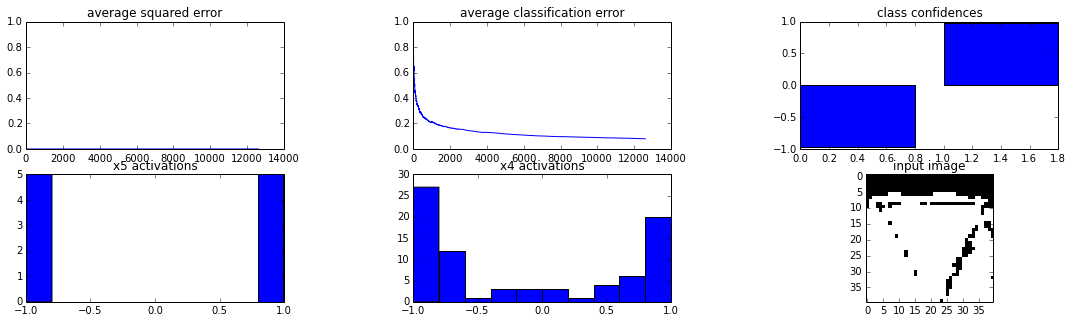

12.9772310257 seconds per 100 iterations


KeyboardInterrupt: 

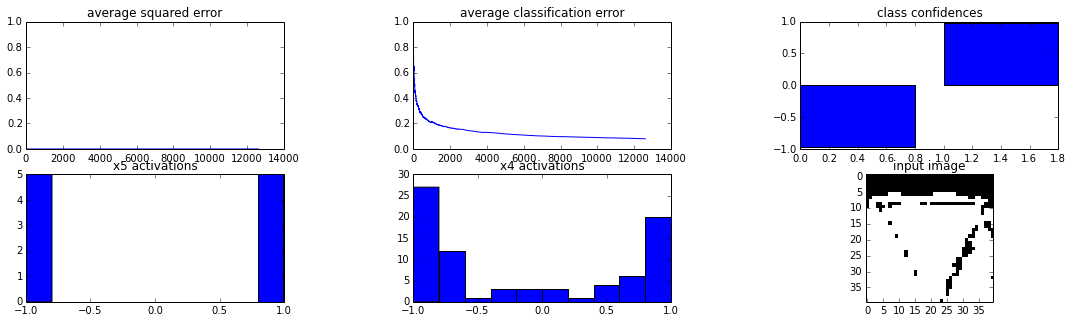

In [21]:
# training

tic = time.time()
disp_freq = 100
for iepoch in range(nepoch):
    errsq = np.zeros(niter)  # never computed
    errcl = np.zeros(niter)
    for iter in xrange(niter):
        # zero pad 28x28 image to make it 32x32
        x0 = train[iter]

        x1 = np.zeros(x1.shape)  # initialize to zero for accumulation
        for i in range(n1):
            for j in range(n0):
                x1[i,:,:] += conv2(x0[j,:,:], w1[i,j,:,:], "valid")
            
        for i in range(n1):
            x1[i,:,:] = x1[i,:,:] + b1[i]
            
        x1 = f(x1)
        
        #x1p, x1w = maxpool(x1)
        
        for i in range(n1):
            x1p[i,:,:] = x1p[i,:,:] + b1p[i]
            
        x1p, x1w = maxpool(x1)
  
        x2 = np.zeros(x2.shape)  # initialize to zero for accumulation
        for i in range(n2):
            for j in range(n1):
                x2[i,:,:] += conv2(x1p[j,:,:], w2[i,j,:,:], "valid")

        for i in range(n2):
            x2[i,:,:] = x2[i,:,:] + b2[i]
          
        x2 = f(x2)
          
        #x2p, x2w = maxpool(x2)
        
        for i in range(n2):
            x2p[i,:,:] = x2p[i,:,:] + b2p[i]
        
        x2p, x2w = maxpool(x2)
        
        x3 = np.zeros(x3.shape)  # initialize to zero for accumulation
        for i in range(n3):
            for j in range(n2):
                x3[i,:,:] += conv2(x2p[j,:,:], w3[i,j,:,:], "valid")

        for i in range(n3):
            x3[i,:,:] = x3[i,:,:] + b3[i]
          
        x3 = f(x3)
          
        x3p, x3w = maxpool(x3)
        
        for i in range(n3):
            x3p[i,:,:] = x3p[i,:,:] + b3p[i]

        # discard 2D organization of x3p by reshaping to x3p(:)
        x4 = f(np.dot(W4,np.reshape(x3p,-1)) + b4)
        x5 = f(np.dot(W5,x4) + b5)
        x6 = f(np.dot(W6,x5) + b6)
        x7 = f(np.dot(W7,x6) + b7)
        prediction = np.argmax(x7);
        errcl[iter] = prediction != trainlabels[iter];
        
        # backward pass
        d = -1*np.ones(n7)
        #d = np.zeros(n7)
        d[trainlabels[iter]] = 1;  # target output vector
        
        ###"
        err = d - x7; 
        delta7 = np.multiply(err,df(x7));
        delta6 = np.multiply(np.dot(W7.T,delta7),df(x6))
        delta5 = np.multiply(np.dot(W6.T,delta6),df(x5))
        delta4 = np.multiply(np.dot(W5.T,delta5),df(x4))
        delta3p = np.dot(W4.T,delta4)
        delta3p = np.reshape(delta3p, x3p.shape)  # restore 2D organization
        delta3 = np.multiply(maxpoolback(delta3p, x3w),df(x3))
        delta2p = np.zeros(x2p.shape)
        for j in range(n2):
            for i in range(n3):
                delta2p[j,:,:] += conv2(delta3[i,:,:], w3[i,j][np.ix_(range(w3.shape[2]-1,-1,-1),range(w3.shape[3]-1,-1,-1))], "full")
        delta2 = np.multiply(maxpoolback(delta2p, x2w),df(x2))       
        delta1p = np.zeros(x1p.shape)
        for j in range(n1):
            for i in range(n2):
                delta1p[j,:,:] += conv2(delta2[i,:,:], w2[i,j][np.ix_(range(w2.shape[2]-1,-1,-1),range(w2.shape[3]-1,-1,-1))], "full")
        delta1 = np.multiply(maxpoolback(delta1p, x1w),df(x1)) 
        
        
        ###LEFT HERE

        # weight updates
        W7 += eta*np.dot(np.atleast_2d(delta7).T,np.atleast_2d(x6))
        W6 += eta*np.dot(np.atleast_2d(delta6).T,np.atleast_2d(x5))
        W5 += eta*np.dot(np.atleast_2d(delta5).T,np.atleast_2d(x4))
        W4 += eta*np.dot(np.atleast_2d(delta4).T,np.reshape(x3p,(1,x3p.size)))
        #W3 += eta*np.dot(np.atleast_2d(delta3).T,np.reshape(x2p,(1,x2p.size)))
        
        #bias updates - same as usual MLP backprop
        b7 += eta*delta7
        b6 += eta*delta6
        b5 += eta*delta5
        b4 += eta*delta4
        #b3 += eta*delta3
        
        #conv bias updates
        #sum over all f_map derivatives for any bias, since they are shared parameters
        #print(delta2p.shape)
        
        for i in range(len(x3p)):
            b3p[i] += eta * np.sum(delta3p[i])
          
        for i in range(len(x3)):
            b3[i] += eta * np.sum(delta3[i])
            
        #NEXT LAYER
            
        for i in range(len(x2p)):
            b2p[i] += eta * np.sum(delta2p[i])
          
        #b2p_update = np.array([np.sum(f_map) for f_map in delta2p])
        #b2p += eta * b2p_update
        
        for i in range(len(x2)):
            b2[i] += eta * np.sum(delta2[i])
          
        #b2_update = np.array([np.sum(f_map) for f_map in delta2])
        #b2 += eta * b2_update
        
        for i in range(len(x1p)):
            b1p[i] += eta * np.sum(delta1p[i])
          
        #b1p_update = np.array([np.sum(f_map) for f_map in delta1p])
        #b1p += eta * b1p_update
        
        for i in range(len(x1)):
            b1[i] += eta * np.sum(delta1[i])
          
        #b1_update = np.array([np.sum(f_map) for f_map in delta1])
        #b1 += eta * b1_update
        
        #update conv kernels
        for i in range(n3):
            for j in range(n2):
                w3[i,j,:,:] += eta*conv2(x2p[j][np.ix_(range(x2p.shape[1]-1,-1,-1),range(x2p.shape[2]-1,-1,-1))], delta3[i,:,:], "valid")
        
        for i in range(n2):
            for j in range(n1):
                w2[i,j,:,:] += eta*conv2(x1p[j][np.ix_(range(x1p.shape[1]-1,-1,-1),range(x1p.shape[2]-1,-1,-1))], delta2[i,:,:], "valid")
        
        
        for i in range(n1):
            for j in range(n0):
                w1[i,j,:,:] += eta*conv2(x0[j][np.ix_(range(x0.shape[1]-1,-1,-1),range(x0.shape[2]-1,-1,-1))], delta1[i,:,:], "valid")
        
        if (iter+1) % disp_freq == 0:
            plt.gcf().clear()
            visualize(iter, errsq, errcl, x7, x6, x5, x4, x0, w1)
            print str(time.time() - tic) + " seconds per " + str(disp_freq) + " iterations"
            tic = time.time()
            time.sleep(0.01)